Loaded KMeans model from disk.
Cluster-to-set mapping saved to disk.
Number of samples in the training set: 12609
Number of samples in the validation set: 1614
Number of samples in the test set: 3639
Train data X shape: (12609, 768)
Train data y shape: (12609, 3, 3)
Train, validation, and test set target distributions:
count                                                 12609
unique                                                 4203
top       [[0.0, 0.0, 0.29], [0.0, 0.0, 0.08], [0.0, 0.0...
freq                                                      3
Name: urban_imperviousness, dtype: object
count                                                  1614
unique                                                  538
top       [[0.0, 0.01, 0.05], [0.0, 0.0, 0.02], [0.0, 0....
freq                                                      3
Name: urban_imperviousness, dtype: object
count                                                  3639
unique                                                 

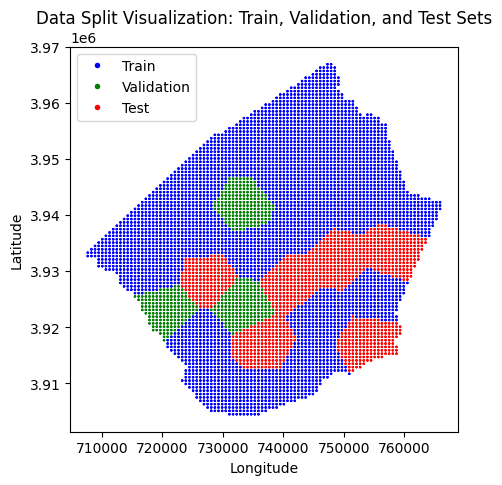

In [3]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import random
from datetime import datetime
from sklearn.cluster import KMeans
import joblib  
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import itertools

# Set a fixed random seed for reproducibility
random.seed(19)
np.random.seed(19)
torch.manual_seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf_train_test = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

# Extract centroid coordinates of each tile
gdf_train_test['centroid'] = gdf_train_test.geometry.centroid

# Decide on the number of clusters
n_clusters = 30  # Adjust based on your requirements
# Use coordinates without scaling
coords = np.array([[geom.x, geom.y] for geom in gdf_train_test['centroid']])

# Path to save the KMeans model
kmeans_model_path = "../artifacts/kmeans_model.pkl"
# Check if the KMeans model already exists
if os.path.exists(kmeans_model_path):
    # Load the saved KMeans model
    kmeans = joblib.load(kmeans_model_path)
    print("Loaded KMeans model from disk.")
else:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=19)
    kmeans.fit(coords)
    # Save the KMeans model to disk
    joblib.dump(kmeans, kmeans_model_path)
    print("KMeans model trained and saved to disk.")
# Assign clusters to the DataFrame
gdf_train_test['cluster'] = kmeans.predict(coords)

# Get unique clusters
clusters = np.sort(gdf_train_test['cluster'].unique())

# Path to save the cluster-to-set mapping
cluster_to_set_path = "../artifacts/cluster_to_set.pkl"
# Check if the cluster-to-set mapping already exists
if os.path.exists(cluster_to_set_path):
    # Load the saved mapping
    with open(cluster_to_set_path, 'rb') as f:
        cluster_to_set = pkl.load(f)
    print("Loaded cluster-to-set mapping from disk.")
else:
    # Shuffle clusters to randomize the assignment
    np.random.shuffle(clusters)
    
    # Split clusters into train, validation, and test sets
    num_clusters = len(clusters)
    train_size = int(0.7 * num_clusters)
    val_size = int(0.1 * num_clusters)
    test_size = num_clusters - train_size - val_size
    
    train_clusters = clusters[:train_size]
    val_clusters = clusters[train_size:train_size + val_size]
    test_clusters = clusters[train_size + val_size:]
    
    # Create a mapping from clusters to sets
    cluster_to_set = {}
    for cluster in train_clusters:
        cluster_to_set[cluster] = 'Train'
    for cluster in val_clusters:
        cluster_to_set[cluster] = 'Validation'
    for cluster in test_clusters:
        cluster_to_set[cluster] = 'Test'
    
    # Save the cluster-to-set mapping
    with open(cluster_to_set_path, 'wb') as f:
        pkl.dump(cluster_to_set, f)
    print("Cluster-to-set mapping saved to disk.")

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)

# Now you can proceed to split the DataFrame based on the 'set' column
train_gdf = gdf_train_test[gdf_train_test['set'] == 'Train'].reset_index(drop=True)
val_gdf = gdf_train_test[gdf_train_test['set'] == 'Validation'].reset_index(drop=True)
test_gdf = gdf_train_test[gdf_train_test['set'] == 'Test'].reset_index(drop=True)

# Define feature and target columns
X_cols = [col for col in gdf_train_test.columns if col.startswith('feature')]
y_col = 'urban_imperviousness'

# Prepare data arrays for train, validation, and test
X_train = train_gdf[X_cols]
y_train = np.stack(train_gdf[y_col].values).reshape(-1, 3, 3)

X_val = val_gdf[X_cols]
y_val = np.stack(val_gdf[y_col].values).reshape(-1, 3, 3)

X_test = test_gdf[X_cols]
y_test = np.stack(test_gdf[y_col].values).reshape(-1, 3, 3)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 9), dtype=torch.float32)  # Flattened 3x3 grids

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 9), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 9), dtype=torch.float32)

# Create a mapping from clusters to sets
cluster_to_set = {}
for cluster in train_clusters:
    cluster_to_set[cluster] = 'Train'
for cluster in val_clusters:
    cluster_to_set[cluster] = 'Validation'
for cluster in test_clusters:
    cluster_to_set[cluster] = 'Test'

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)

# Display the number of samples in each split
print(f"Number of samples in the training set: {len(train_gdf)}")
print(f"Number of samples in the validation set: {len(val_gdf)}")
print(f"Number of samples in the test set: {len(test_gdf)}")

print("Train data X shape:", X_train.values.shape)
print("Train data y shape:", y_train.shape)

print("Train, validation, and test set target distributions:")
# Training set distribution
print(train_gdf['urban_imperviousness'].describe())
# Validation set distribution
print(val_gdf['urban_imperviousness'].describe())
# Test set distribution
print(test_gdf['urban_imperviousness'].describe())


# Plot the data points colored by 'set'
plt.figure(figsize=(5, 5))

# Define colors for each set
colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}

# Map 'set' labels to colors
point_colors = gdf_train_test['set'].map(colors)

# Plot
plt.scatter(coords[:, 0], coords[:, 1], c=point_colors, s=0.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Validation', markerfacecolor='green', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='red', markersize=5)
]

plt.legend(handles=legend_elements, loc='best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Split Visualization: Train, Validation, and Test Sets')
plt.show()

In [4]:
# Baseline Model

# Calculate the mean urban imperviousness for each cell in the 3x3 grid across the training set
baseline_prediction = np.mean(y_train, axis=0)
print("Baseline prediction (3x3 grid):\n", baseline_prediction)

# Flatten the true and predicted 3x3 grids to apply the metrics for the test set
y_test_flat = y_test.reshape(-1, 9)  # Flatten each 3x3 grid in y_test to a 9-element vector

# Repeat the baseline prediction for each sample in y_test for comparison
baseline_pred = np.tile(baseline_prediction.flatten(), (y_test_flat.shape[0], 1))

# Calculate baseline metrics on the test set
mse_baseline = mean_squared_error(y_test_flat, baseline_pred)
mae_baseline = mean_absolute_error(y_test_flat, baseline_pred)

print(f"Baseline MSE on Test Set: {mse_baseline}")
print(f"Baseline MAE on Test Set: {mae_baseline}")

Baseline prediction (3x3 grid):
 [[0.03193201 0.03298827 0.03228182]
 [0.03320245 0.03320238 0.03282656]
 [0.03361407 0.03371402 0.03321914]]
Baseline MSE on Test Set: 0.0051237172447144985
Baseline MAE on Test Set: 0.03848246484994888


In [21]:
def train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor=None, 
    y_val_tensor=None, 
    epochs=100, 
    criterion=None,  
    optimizer=None, 
    scheduler=None,
    lr=0.001, 
    batch_size=32, 
    verbose=True,
    use_batch_processing=True, 
    early_stopping=False,  
    patience=10,  
    min_delta=0.0 
):
    # Set up criterion if none is provided
    if criterion is None:
        criterion = nn.MSELoss()
    
    # Set up optimizer if none is provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Create DataLoader for batch processing if enabled
    if use_batch_processing:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        # No batch processing; use the entire dataset in each pass
        train_loader = [(X_train_tensor, y_train_tensor)]
    
    # Early stopping initialization
    best_loss = float('inf')
    patience_counter = 0
    
    # Initialize lists to record loss history
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        # Calculate average training loss
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)  # Record training loss
    
        # Validation phase
        if X_val_tensor is not None and y_val_tensor is not None:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)  # Record validation loss
    
            # Adjust learning rate with scheduler
            if scheduler is not None:
                scheduler.step(val_loss)
    
            # Early stopping
            if early_stopping:
                # Check for improvement
                if val_loss < best_loss - min_delta:
                    best_loss = val_loss
                    patience_counter = 0  # Reset patience if there is improvement
                else:
                    patience_counter += 1  # Increment patience if no improvement
    
                # Stop training if patience is exceeded
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch + 1} with Validation Loss: {best_loss:.6f}")
                    break
        else:
            # If no validation data, consider using training loss for scheduler
            if scheduler is not None:
                scheduler.step(avg_loss)
            val_losses.append(None)
    
        # Print epoch loss every 10 epochs if verbose is enabled
        if verbose and (epoch + 1) % 10 == 0:
            msg = f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.6f}'
            if X_val_tensor is not None and y_val_tensor is not None:
                msg += f', Validation Loss: {val_loss:.6f}'
            print(msg)
    
    return model, train_losses, val_losses

def plot_train_val_losses(train_losses, val_losses):
    # Create a range for the number of epochs
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(6, 3))
    plt.plot(epochs_range, train_losses, label='Training Loss')
    # Check if validation losses are recorded (not None)
    if any(v is not None for v in val_losses):
        plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

# Simple fully connected (dense) neural network 
class SimpleNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Deep Fully Connected Neural Network
class DeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128, dropout_rate=0.5):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

# Define hyperparameter grid
hyperparameter_grid = {
    'model_type': ['SimpleNN', 'DeepNN'],
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'weight_decay': [0, 1e-5, 1e-4],
    'learning_rate': [0.0005, 0.001],
    'patience': [10, 20, 30],
    'criterion': ['MSELoss', 'SmoothL1Loss'],  # Loss functions to try
}

# Generate all combinations of hyperparameters
hyperparameter_list = list(itertools.product(
    hyperparameter_grid['model_type'],
    hyperparameter_grid['hidden_units'],
    hyperparameter_grid['dropout_rate'],
    hyperparameter_grid['weight_decay'],
    hyperparameter_grid['learning_rate'],
    hyperparameter_grid['patience'],
    hyperparameter_grid['criterion'],
))

In [ ]:
# Directory to save models
model_dir = '../artifacts/iterative_models'
os.makedirs(model_dir, exist_ok=True)

# Function to create a unique model name
def create_model_name(params):
    model_name = f"{params['model_type']}_hu{params['hidden_units']}_dr{params['dropout_rate']}_wd{params['weight_decay']}_lr{params['learning_rate']}_pat{params['patience']}_crit{params['criterion']}"
    return model_name

# Loop over hyperparameter combinations
for hp_values in hyperparameter_list:
    # Create a dictionary of hyperparameters
    params = {
        'model_type': hp_values[0],
        'hidden_units': hp_values[1],
        'dropout_rate': hp_values[2],
        'weight_decay': hp_values[3],
        'learning_rate': hp_values[4],
        'patience': hp_values[5],
        'criterion': hp_values[6],
    }
    
    # Create a unique model name
    model_name = create_model_name(params)
    model_filepath = os.path.join(model_dir, model_name + '.pkl')
    
    # Check if model already exists
    if os.path.exists(model_filepath):
        # print(f"Model {model_name} already exists. Skipping training.")
        continue  # Skip to the next hyperparameter combination
    
    print(f"Training model {model_name}...")
    
    # Define the model based on model_type
    if params['model_type'] == 'SimpleNN':
        model = SimpleNN(input_size=768, 
                         output_size=9,
                         hidden_units=params['hidden_units'], 
                         dropout_rate=params['dropout_rate'])
    
    elif params['model_type'] == 'DeepNN':
        model = DeepNN(input_size=768, 
                       output_size=9, 
                       hidden_units=params['hidden_units'], 
                       dropout_rate=params['dropout_rate'])
    else:
        print(f"Unknown model type: {params['model_type']}. Skipping.")
        continue  # Skip to the next hyperparameter combination
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), 
                           lr=params['learning_rate'], 
                           weight_decay=params['weight_decay'])
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Define criterion
    if params['criterion'] == 'MSELoss':
        criterion = nn.MSELoss()
    elif params['criterion'] == 'SmoothL1Loss':
        criterion = nn.SmoothL1Loss()
    else:
        print(f"Unknown criterion: {params['criterion']}. Skipping.")
        continue  # Skip to the next hyperparameter combination
    
    # Train the model
    trained_model, train_losses, val_losses = train_model(
        model=model,
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_val_tensor=X_val_tensor,
        y_val_tensor=y_val_tensor,
        epochs=100,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        lr=params['learning_rate'],
        batch_size=64,
        verbose=False,  # Set to False to reduce output
        use_batch_processing=True,
        early_stopping=True,
        patience=params['patience'],
        min_delta=0.0001
    )
    
    # Prediction on test data
    with torch.no_grad():
        test_pred = trained_model(X_test_tensor)
    
    # Calculate metrics
    mse = nn.MSELoss()(test_pred, y_test_tensor).item()
    mae = nn.L1Loss()(test_pred, y_test_tensor).item()
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}\nRMSE: {rmse}\nMAE: {mae}")

    # Save all artifacts
    artifacts = {
        'model_name': model_name,
        'hyperparameters': params,
        'model_state_dict': trained_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_predictions': test_pred.numpy(),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
    }
    
    with open(model_filepath, 'wb') as f:
        pkl.dump(artifacts, f)
    
    print(f"Model {model_name} trained and saved.")

In [ ]:
# Collect metrics from all saved models
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

metrics_list = []
for model_file in model_files:
    with open(model_file, 'rb') as f:
        artifacts = pkl.load(f)
    metrics = {
        'model_name': artifacts['model_name'],
        'mse': artifacts['mse'],
        'mae': artifacts['mae'],
        'rmse': artifacts['rmse'],
        'hyperparameters': artifacts['hyperparameters'],
    }
    metrics_list.append(metrics)

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(metrics_list)

# Sort metrics
metrics_df = metrics_df.sort_values(by='mse').reset_index(drop=True)
print(metrics_df[['model_name', 'rmse', 'mse', 'mae']])


                                            model_name      rmse       mse  \
0     DeepNN_hu64_dr0.1_wd0_lr0.0005_pat10_critMSELoss  0.045075  0.002032   
1    DeepNN_hu128_dr0.2_wd0.0001_lr0.0005_pat20_cri...  0.045246  0.002047   
2    DeepNN_hu64_dr0.1_wd0.0001_lr0.001_pat10_critS...  0.045267  0.002049   
3    DeepNN_hu64_dr0.1_wd0.0001_lr0.001_pat10_critM...  0.045280  0.002050   
4    DeepNN_hu128_dr0.1_wd0_lr0.0005_pat10_critMSELoss  0.045344  0.002056   
..                                                 ...       ...       ...   
767  SimpleNN_hu64_dr0.5_wd1e-05_lr0.001_pat30_crit...  0.074756  0.005588   
768  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat20_crit...  0.078117  0.006102   
769  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat10_crit...  0.084617  0.007160   
770  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat20_crit...  0.094035  0.008843   
771  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat10_crit...  0.094036  0.008843   

          mae  
0    0.019629  
1    0.019230  
2    0.021024  

In [27]:
metrics_df = metrics_df.sort_values(by='mae').reset_index(drop=True)
print(metrics_df[['model_name', 'rmse', 'mse', 'mae']])

                                            model_name      rmse       mse  \
0    DeepNN_hu32_dr0.5_wd0.0001_lr0.001_pat30_critS...  0.048158  0.002319   
1    DeepNN_hu64_dr0.5_wd0.0001_lr0.0005_pat30_crit...  0.048167  0.002320   
2    SimpleNN_hu64_dr0.5_wd0.0001_lr0.001_pat20_cri...  0.047685  0.002274   
3    DeepNN_hu32_dr0.3_wd0.0001_lr0.0005_pat30_crit...  0.048528  0.002355   
4    SimpleNN_hu32_dr0.5_wd0.0001_lr0.001_pat30_cri...  0.048867  0.002388   
..                                                 ...       ...       ...   
767  DeepNN_hu64_dr0.5_wd0.0001_lr0.001_pat30_critS...  0.067367  0.004538   
768  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat20_crit...  0.078117  0.006102   
769  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat10_crit...  0.084617  0.007160   
770  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat20_crit...  0.094035  0.008843   
771  DeepNN_hu128_dr0.5_wd0.0001_lr0.001_pat10_crit...  0.094036  0.008843   

          mae  
0    0.018251  
1    0.018305  
2    0.018344  